# Importing Libraries

In [768]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import ccf

# Function Declaration

In [769]:
def load_data(folder_path):
    dataframes = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            category = os.path.splitext(filename)[0]
            df['Category'] = category
            dataframes.append(df)
    if dataframes:
        merged_data = pd.concat(dataframes, ignore_index=True)
        merged_data['Date'] = pd.to_datetime(merged_data['Date'])
    else:
        print("No CSV files found in the specified folder.")
        return pd.DataFrame()

    return merged_data

In [770]:
def time_series_plot(data):
    features = data.columns[:-1]
    categories = data['Category'].unique()

    fig, axes = plt.subplots(len(features), len(categories), figsize=(30, 20), sharex=True)

    for i, feature in enumerate(features):
        for j, category in enumerate(categories):
            subset = data[data['Category'] == category].copy()
            axes[i, j].plot(subset.index, subset[feature], label=category)
            axes[i, j].set_title(f'{feature} - {category}')
            axes[i, j].set_ylabel(feature)
            axes[i, j].legend()

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [771]:
def moving_average_plot(data, window):
    features = data.columns[:-1]
    categories = data['Category'].unique()

    fig, axes = plt.subplots(len(features), len(categories), figsize=(30, 20), sharex=True)

    for i, feature in enumerate(features):
        for j, category in enumerate(categories):
            subset = data[data['Category'] == category].copy()
            subset['Moving Average'] = subset[feature].rolling(window=window).mean()
            axes[i, j].plot(subset.index, subset[feature], label='Original')
            axes[i, j].plot(subset.index, subset['Moving Average'], label='Moving Average', color='red')
            axes[i, j].set_title(f'{feature} - {category}')
            axes[i, j].set_ylabel(feature)
            axes[i, j].legend()

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [772]:
def acf_pacf_plot(data):
    features = data.columns[:-1]
    categories = data['Category'].unique()

    fig, axes = plt.subplots(len(features), len(categories), figsize=(30, 20), sharex=True)

    for i, feature in enumerate(features):
        for j, category in enumerate(categories):
            subset = data[data['Category'] == category].copy()
            plot_acf(subset[feature], ax=axes[i, j], lags=30)
            plot_pacf(subset[feature], ax=axes[i, j], lags=30)
            axes[i, j].set_title(f'{feature} - {category}')

    plt.xlabel('Lag')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [773]:
def adf_test(data):
    features = data.columns[:-1]
    categories = data['Category'].unique()
    for feature in features:
        for category in categories:
            subset = data[data['Category'] == category][feature].copy()
            if subset.nunique() <= 1:
                print(f'Skipping ADF test for {feature} - {category}: constant values')
                continue
            if subset.isnull().values.any():
                print(f'Skipping ADF test for {feature} - {category}: missing values')
                continue
            result = adfuller(subset)
            print(f'ADF Statistic for {feature} - {category}: {result[0]}')
            print(f'p-value: {result[1]}')
            print(f'Critical Values: {result[4]}')
            if result[1] > 0.05:
                print(f'{feature} - {category} is not stationary')
            else:
                print(f'{feature} - {category} is stationary')
            print('')

In [774]:
def corr_matrix(data):
    categories = data['Category'].unique() 
    features = data.columns.drop('Category')
    fig, axes = plt.subplots(1, len(categories), figsize=(20, 8), sharey=True)

    for ax, category in zip(axes, categories):
        subset = data[data['Category'] == category].drop(columns='Category')
        corr = subset.corr()
        sns.heatmap(corr, annot=True, ax=ax, cmap='coolwarm', cbar=False)
        ax.set_title(f'Correlation Matrix - {category}')

    plt.tight_layout()
    plt.show()

In [775]:
def differentiate_count(data):
    data.columns = data.columns.str.strip()
    
    
    differenced_data = pd.DataFrame()
    differencing_counts = {}
    
    for feature in data.columns:
        if feature in {'Category', 'Date'}:
            continue
        
        for category in data['Category'].unique():
            subset = data[data['Category'] == category][feature].copy()
            
            if subset.nunique() <= 1 or subset.isnull().values.any():
                continue
            
            subset = subset.dropna()
            
            d = 0
            while d <= d_max:
                result = adfuller(subset)
                if result[1] <= 0.05:
                    break
                d += 1
                subset = subset.diff().dropna()
            date_subset = data[data['Category'] == category]['Date'].iloc[d:].reset_index(drop=True)
            temp_df = pd.DataFrame({
                'Date': date_subset,
                feature: subset.reset_index(drop=True),
                'Category': category
            })
            differenced_data = pd.concat([differenced_data, temp_df], ignore_index=True)
            differencing_counts[(feature, category)] = d

    return differenced_data, differencing_counts

In [794]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def differentiate_count2(data, d_max=5):
    data.columns = data.columns.str.strip()
    
    differenced_data = pd.DataFrame()
    differencing_counts = {}
    
    grouped = data.groupby('Category')
    
    for category, group in grouped:
        group = group.sort_values('Date')  # Ensure the data is sorted by date
        for feature in group.columns:
            if feature in {'Category', 'Date'}:
                continue
            
            subset = group[feature].dropna()
            
            # Skip features that are constant or have too many NaNs
            if subset.nunique() <= 1 or len(subset) < 2:
                print(f"Skipping feature: {feature} in category: {category} due to insufficient variability or data.")
                continue
            
            original_length = len(subset)
            d = 0
            
            # Create a copy of the original subset to fill NaNs later
            original_values = subset.copy()
            
            while d <= d_max:
                result = adfuller(subset)
                if result[1] <= 0.05:
                    break
                d += 1
                subset = subset.diff().dropna()
            
            # Store the differencing count for the feature and category
            differencing_counts[(category, feature)] = d
            
            if d > 0:
                # Fill NaNs with the last valid observation
                valid_subset = subset.fillna(method='ffill')
                valid_length = len(valid_subset)
                
                # Align the dates with the valid subset
                date_subset = group['Date'].iloc[d:original_length].reset_index(drop=True)
                temp_df = pd.DataFrame({
                    'Date': date_subset[:valid_length].reset_index(drop=True),
                    feature: valid_subset.reset_index(drop=True),
                    'Category': category
                })
                
                differenced_data = pd.concat([differenced_data, temp_df], ignore_index=True)
            else:
                # If no differencing was needed, keep the original values
                temp_df = group[['Date', feature, 'Category']].copy()
                differenced_data = pd.concat([differenced_data, temp_df], ignore_index=True)

    # Fill NaNs with original values where applicable
    for feature in data.columns:
        if feature in {'Category', 'Date'}:
            continue
        if feature in differenced_data.columns:
            # Fill NaNs with original values from the input data
            original_values = data[data['Category'] == differenced_data['Category'].iloc[0]][feature]
            differenced_data[feature] = differenced_data[feature].combine_first(original_values)
        else:
            # If the feature was never added, we can add it as a column of original values
            differenced_data[feature] = data[data['Category'] == differenced_data['Category'].iloc[0]][feature]

    # Reset index for the final DataFrame
    differenced_data.reset_index(drop=True, inplace=True)

    # Optionally, fill remaining NaNs using backward fill
    differenced_data.fillna(method='bfill', inplace=True)  # Backward fill

    # Ensure we return the expected values
    return differenced_data, differencing_counts

# Example usage
# Ensure 'uang' is a valid DataFrame with the expected structure
# uang2, d_uang = differentiate_count2(uang)

# Data Preparation

In [778]:
uang = load_data(r'C:\Users\farel\OneDrive\Documents\GitHub\Arkavidia-9\Mata Uang')
com = load_data(r'C:\Users\farel\OneDrive\Documents\GitHub\Arkavidia-9\Global Commodity Price')

In [779]:
uang.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'Category'],
      dtype='object')

In [780]:
cols = ['Price', 'Open', 'High', 'Low', 'Change %', 'Vol.']
com[cols] = com[cols].replace({'\$':'', ',':'', '%':'', 'K':'000'}, regex=True)
com[cols] = com[cols].apply(pd.to_numeric, errors='coerce')

In [781]:
uang['Date'] = pd.to_datetime(uang['Date'])
uang1 = uang.set_index('Date')
com['Date'] = pd.to_datetime(com['Date'])
com1 = com.set_index('Date')

# EDA

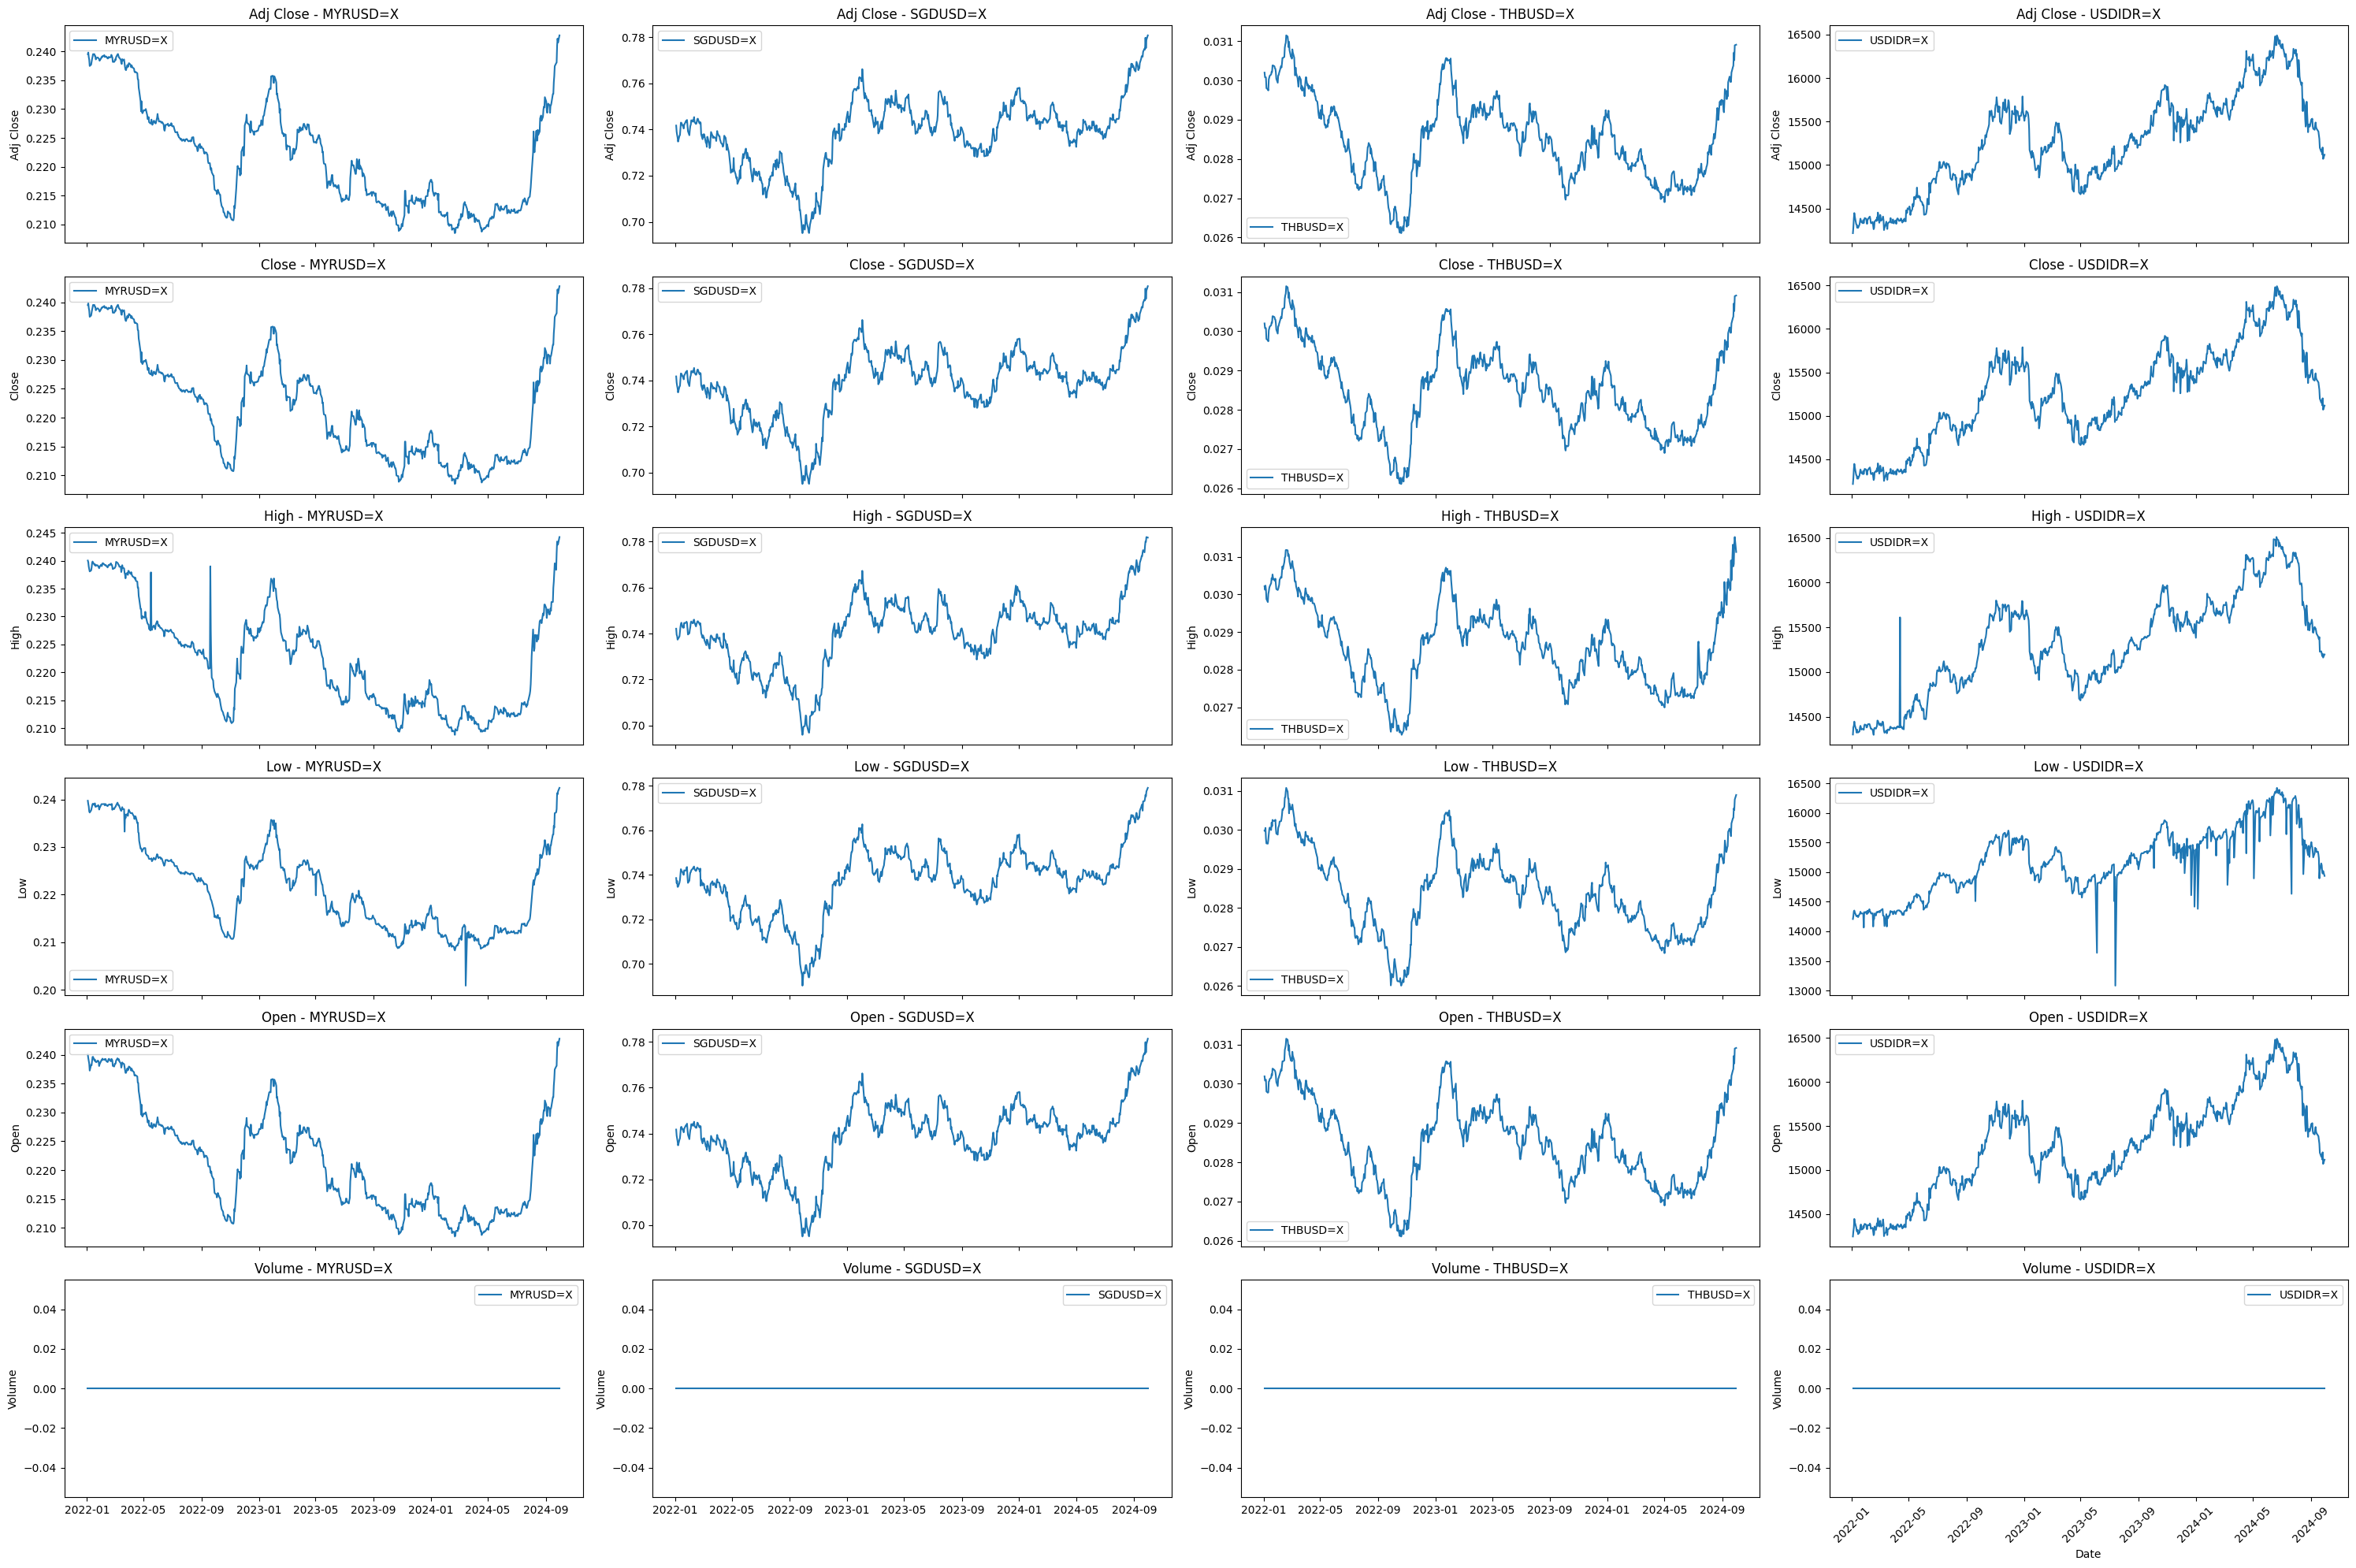

In [ ]:
time_series_plot(uang1)

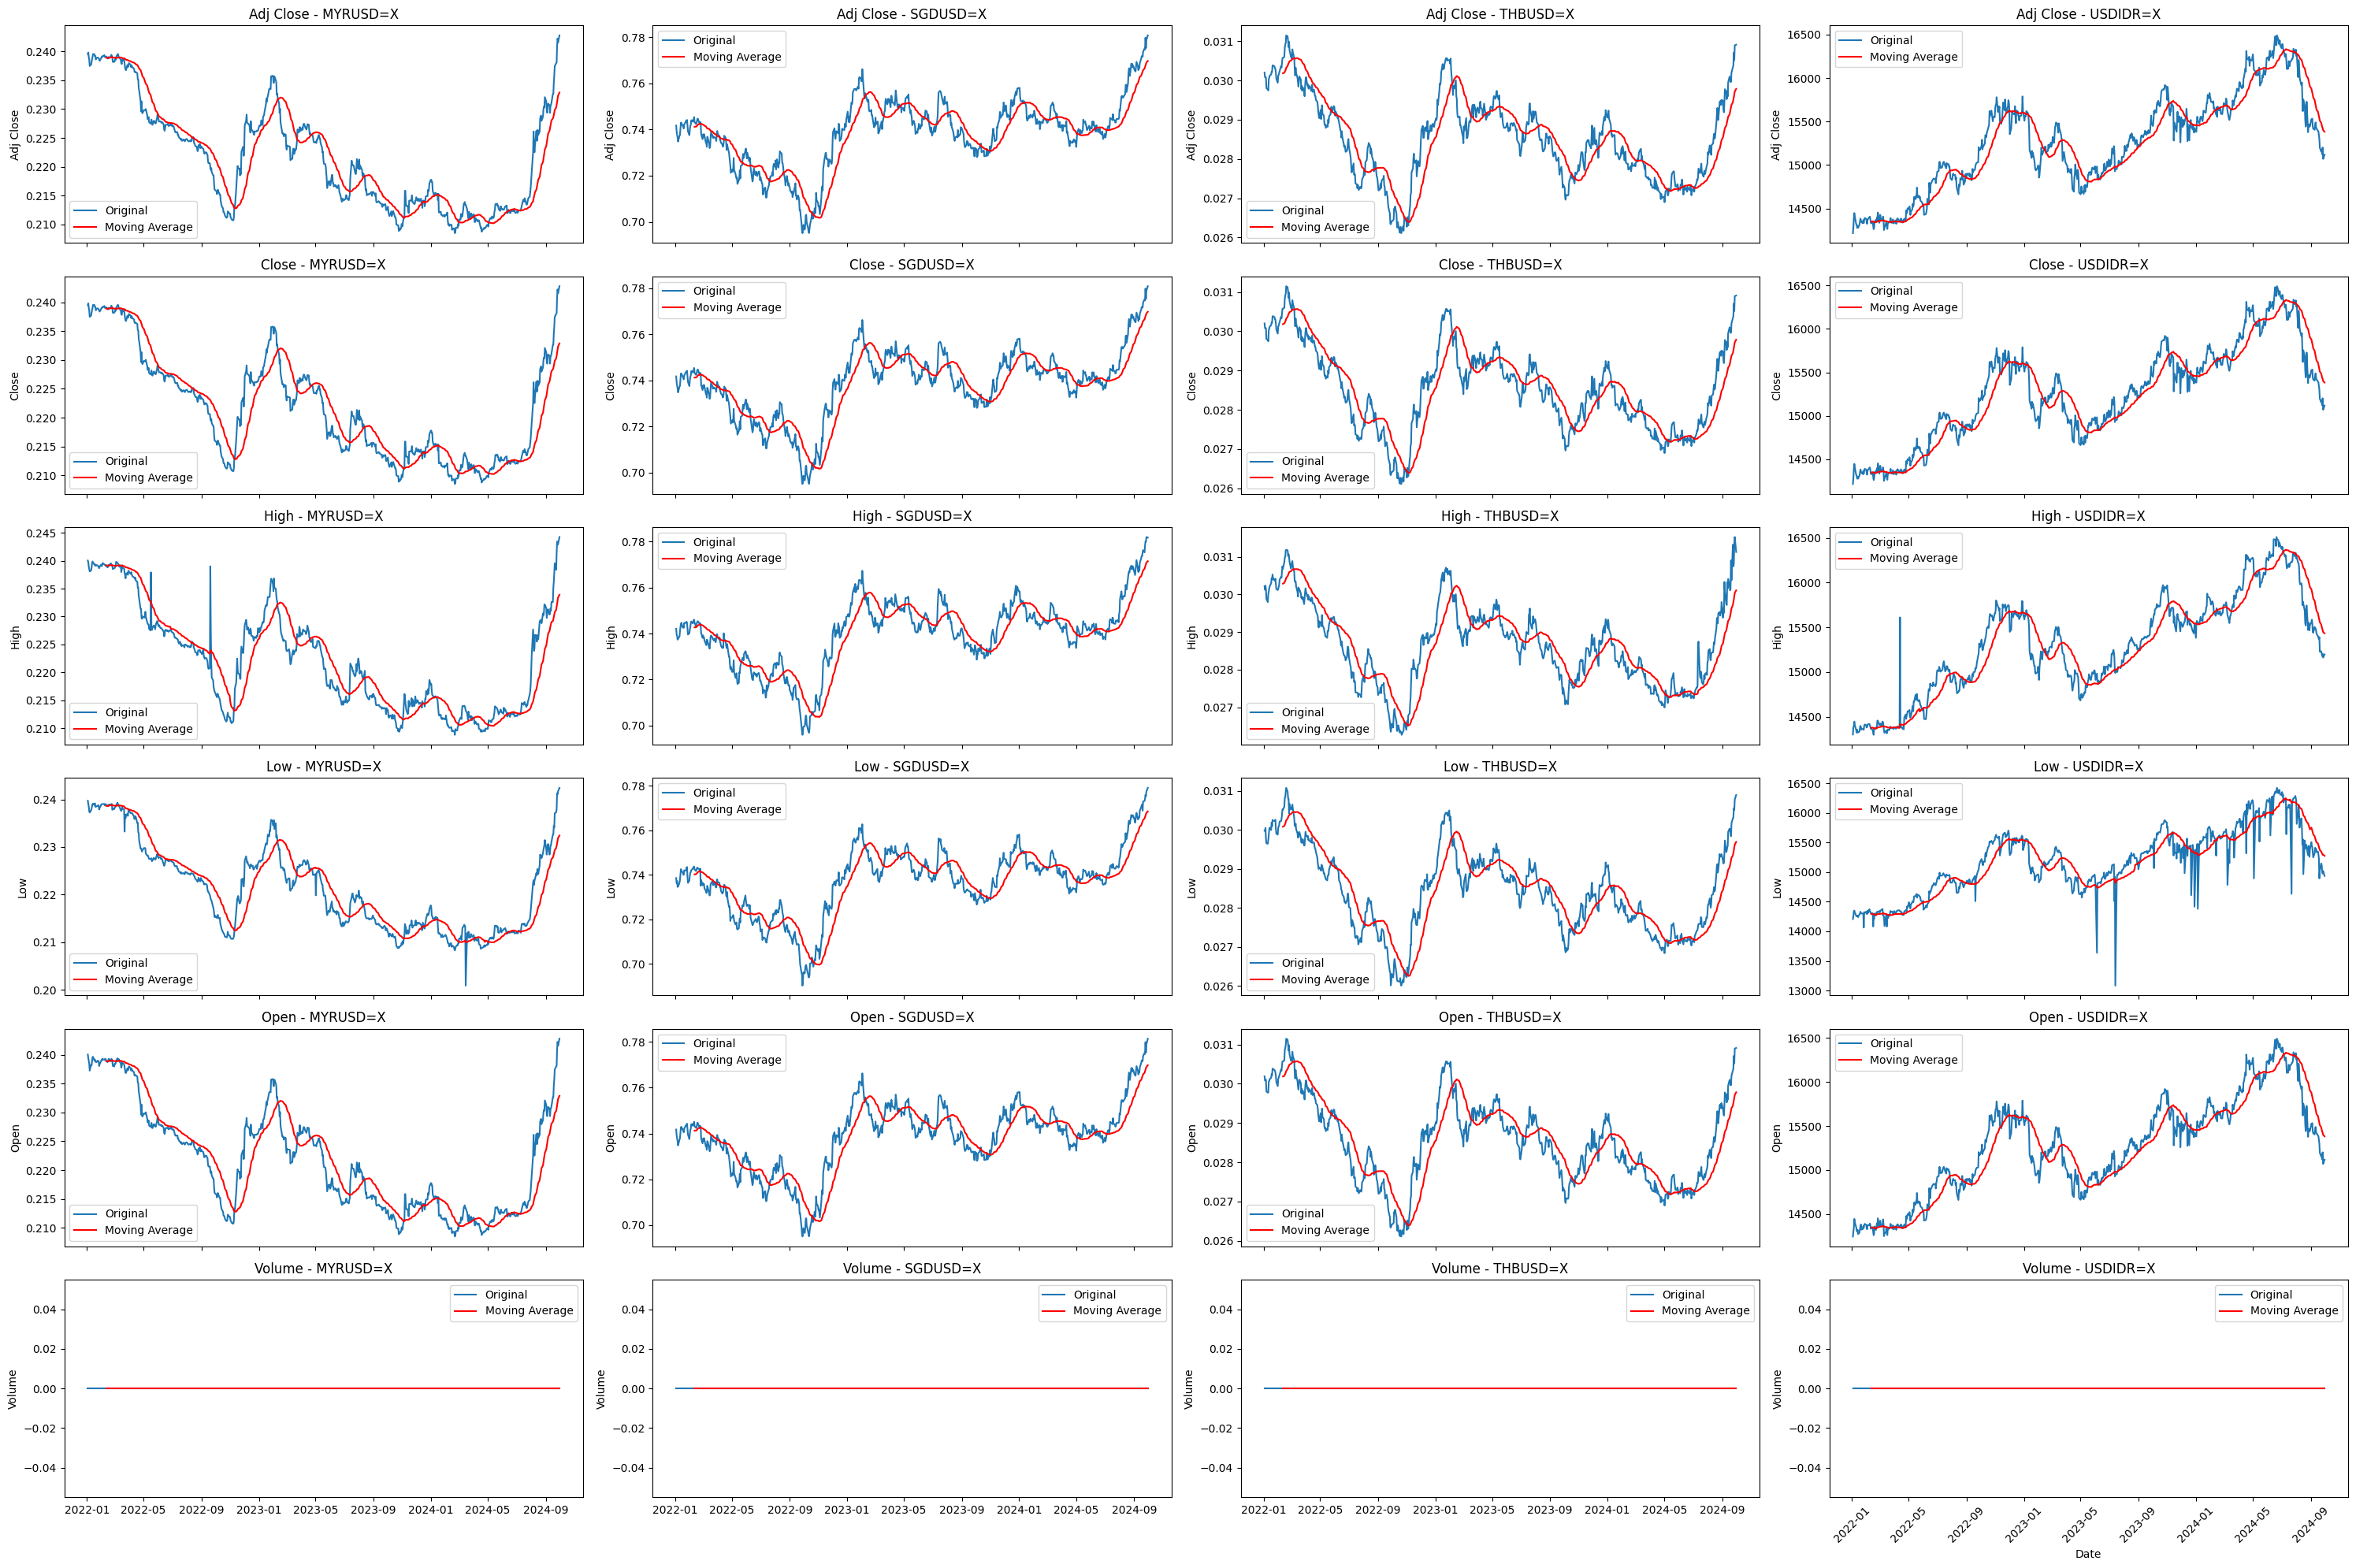

In [ ]:
moving_average_plot(uang1, 30)

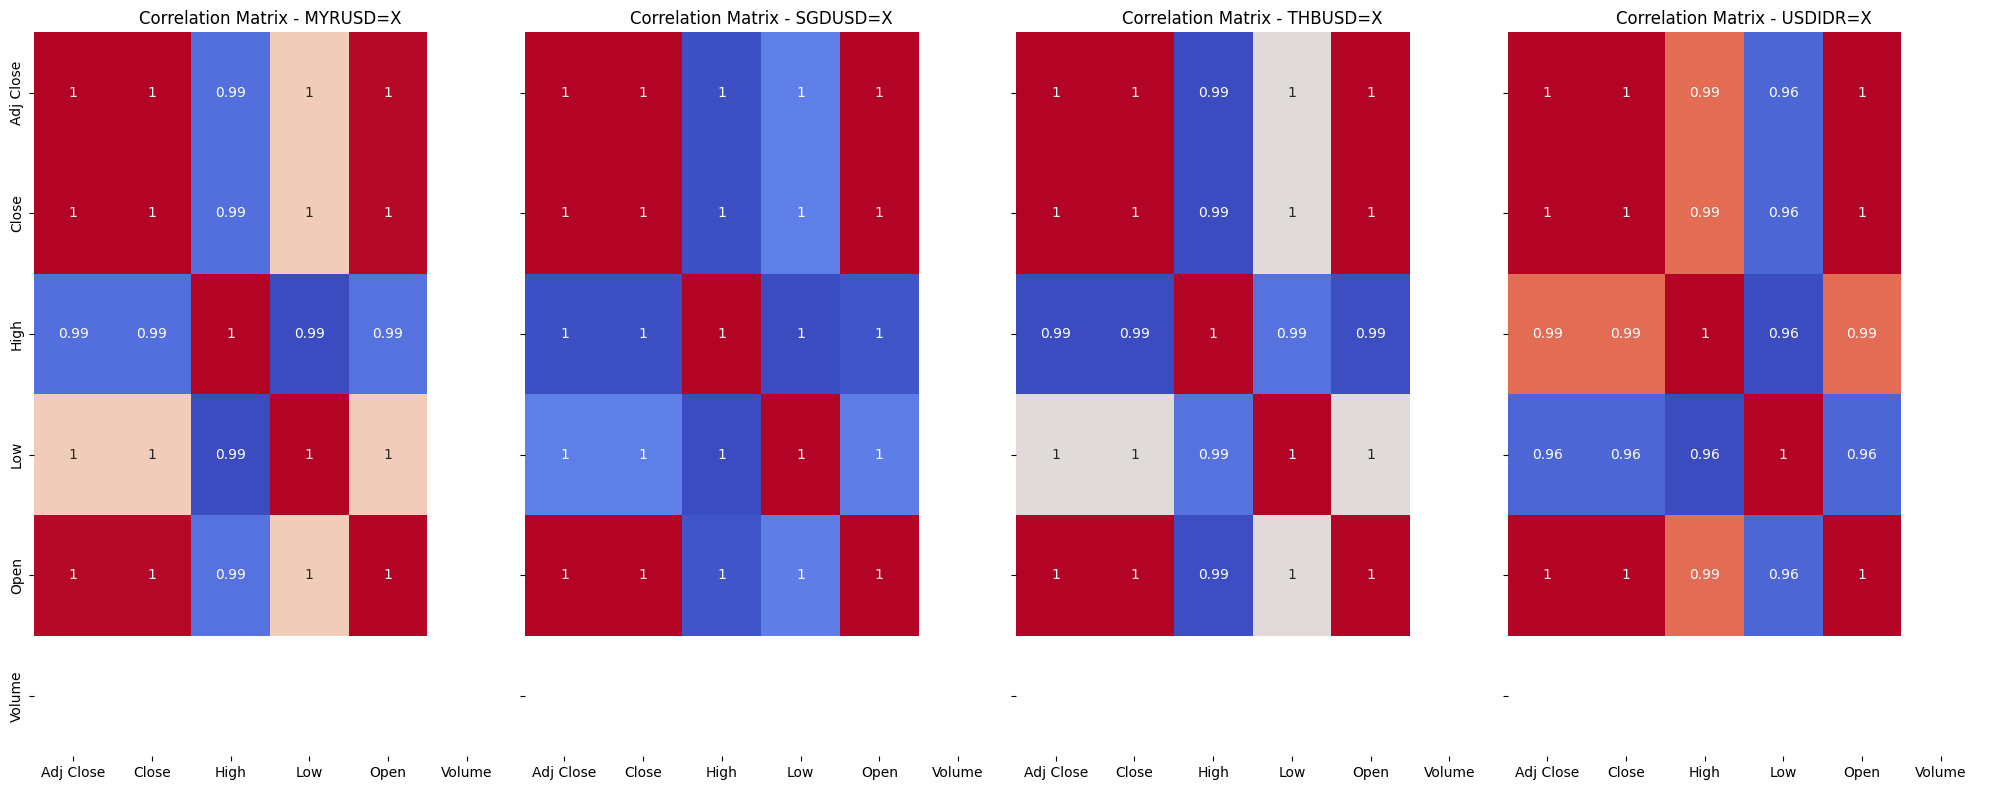

In [ ]:
corr_matrix(uang1)

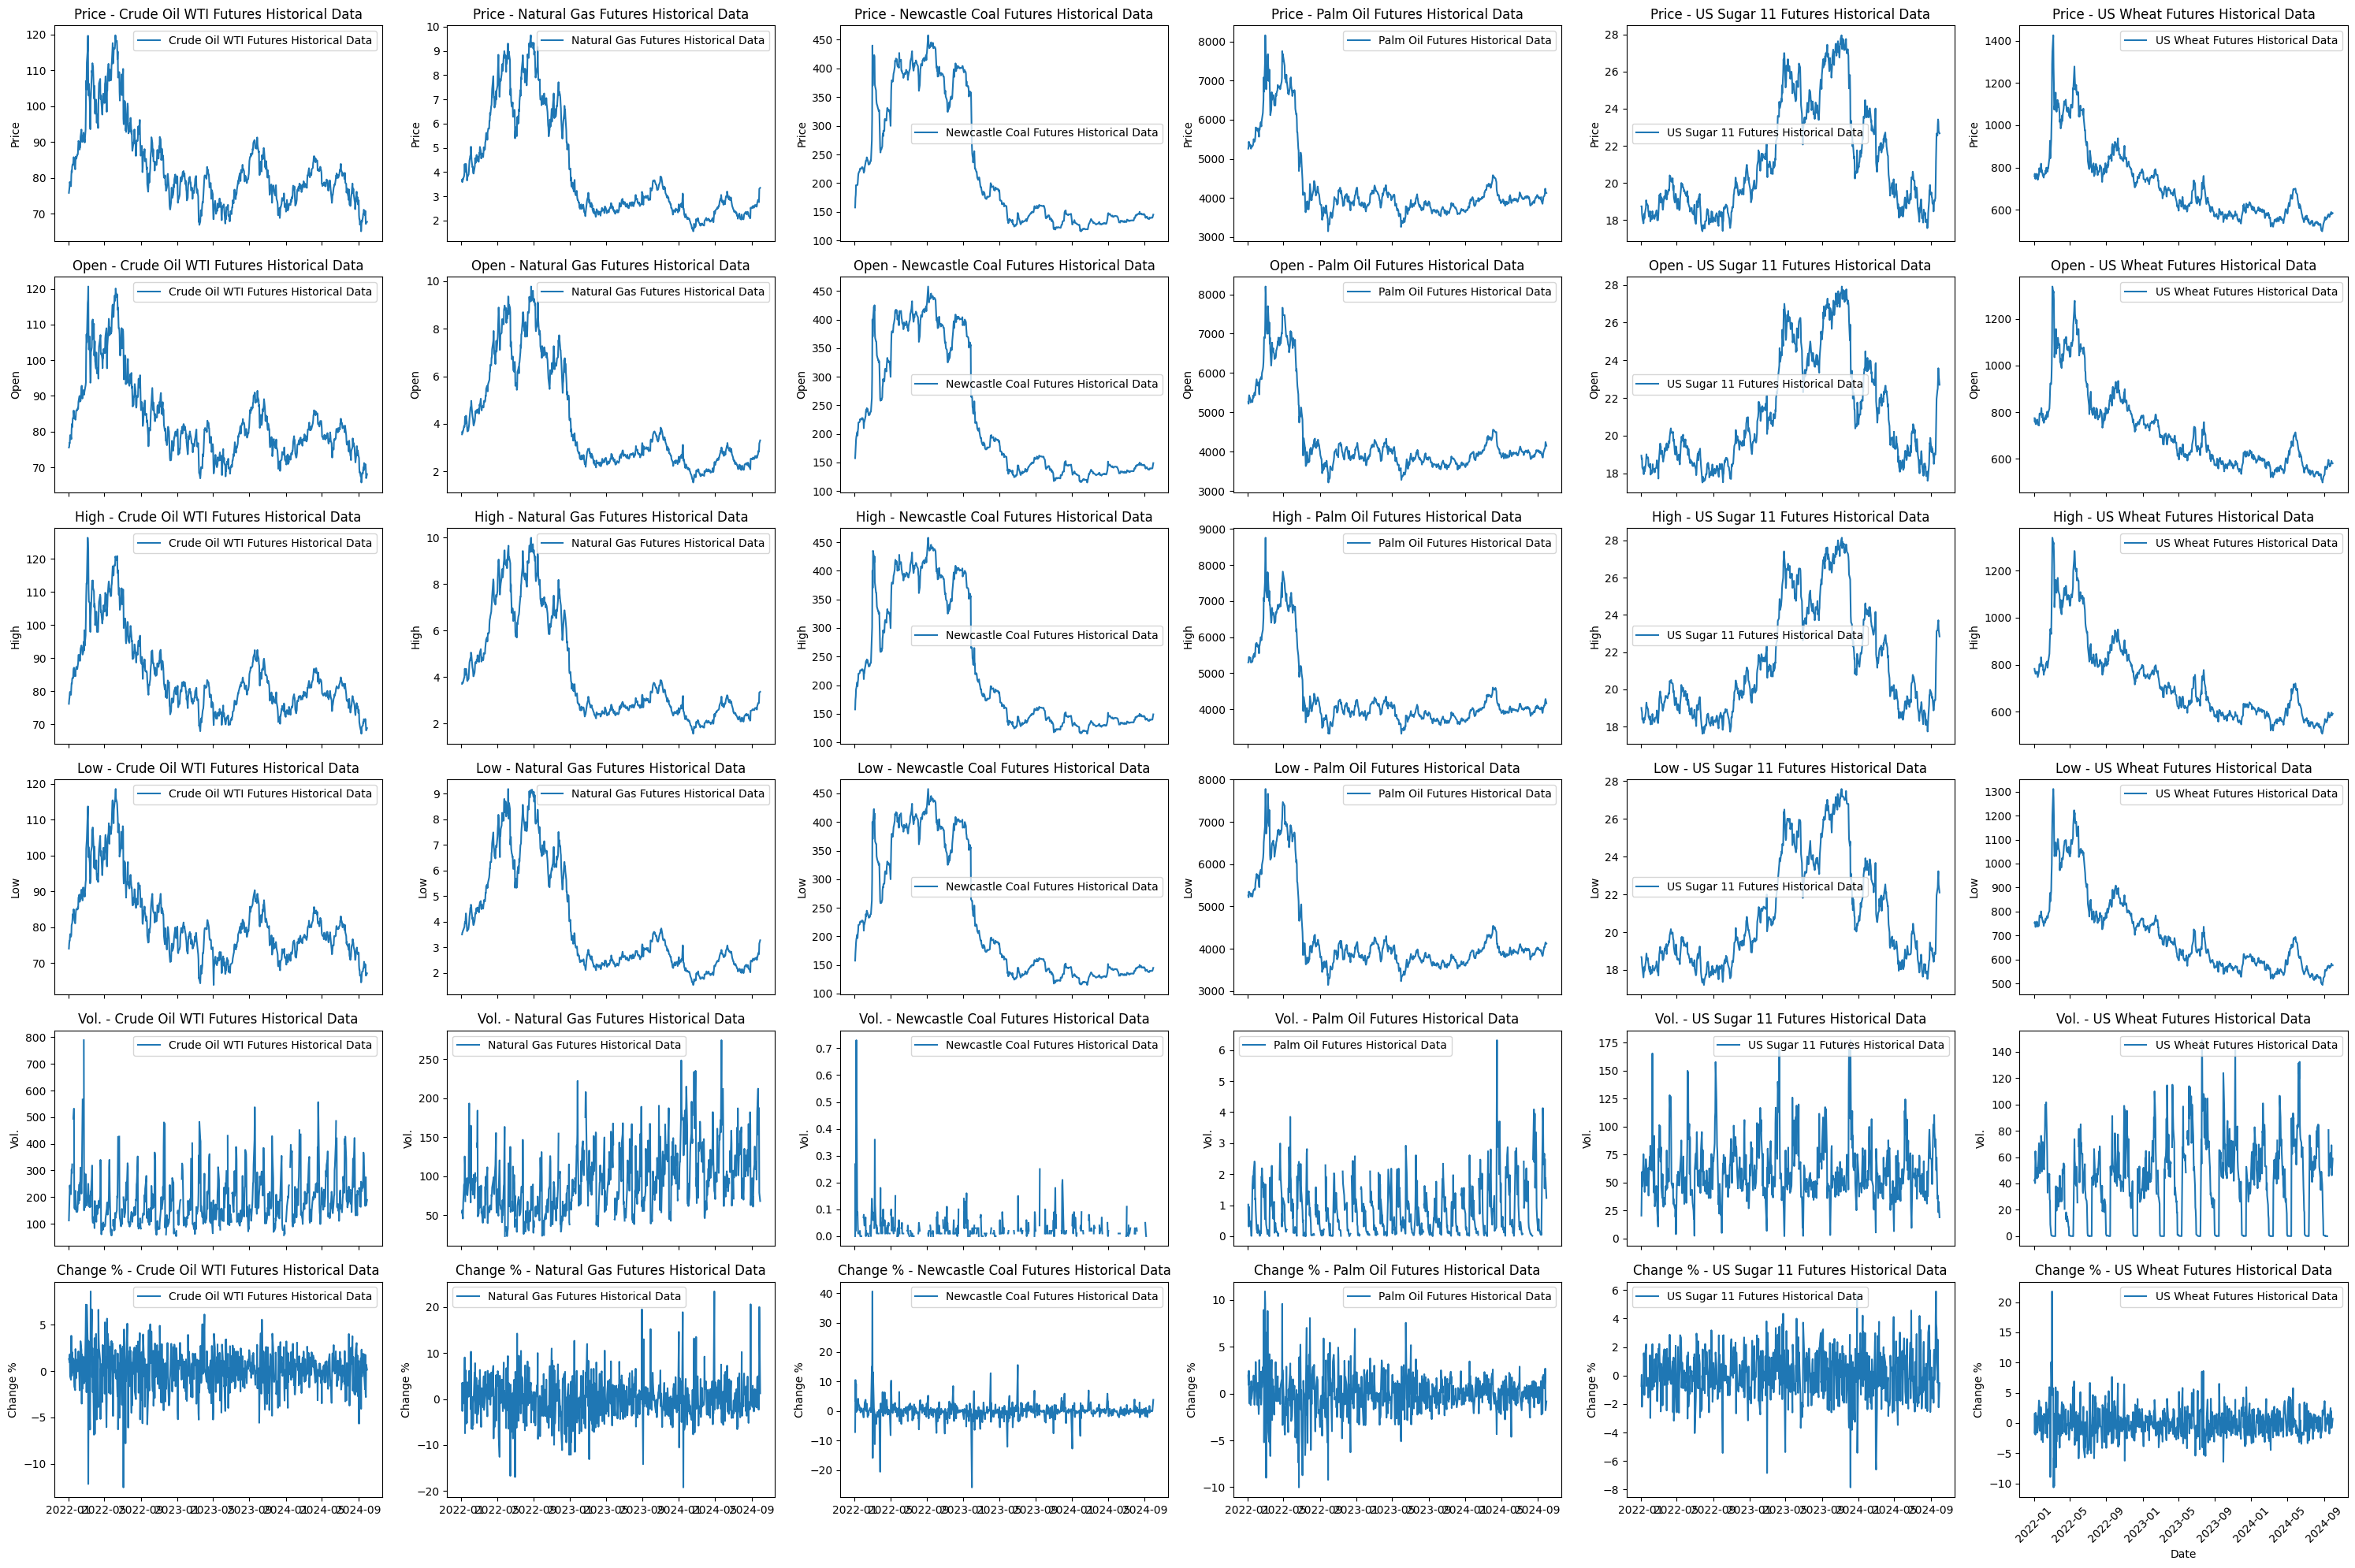

In [ ]:
time_series_plot(com1)

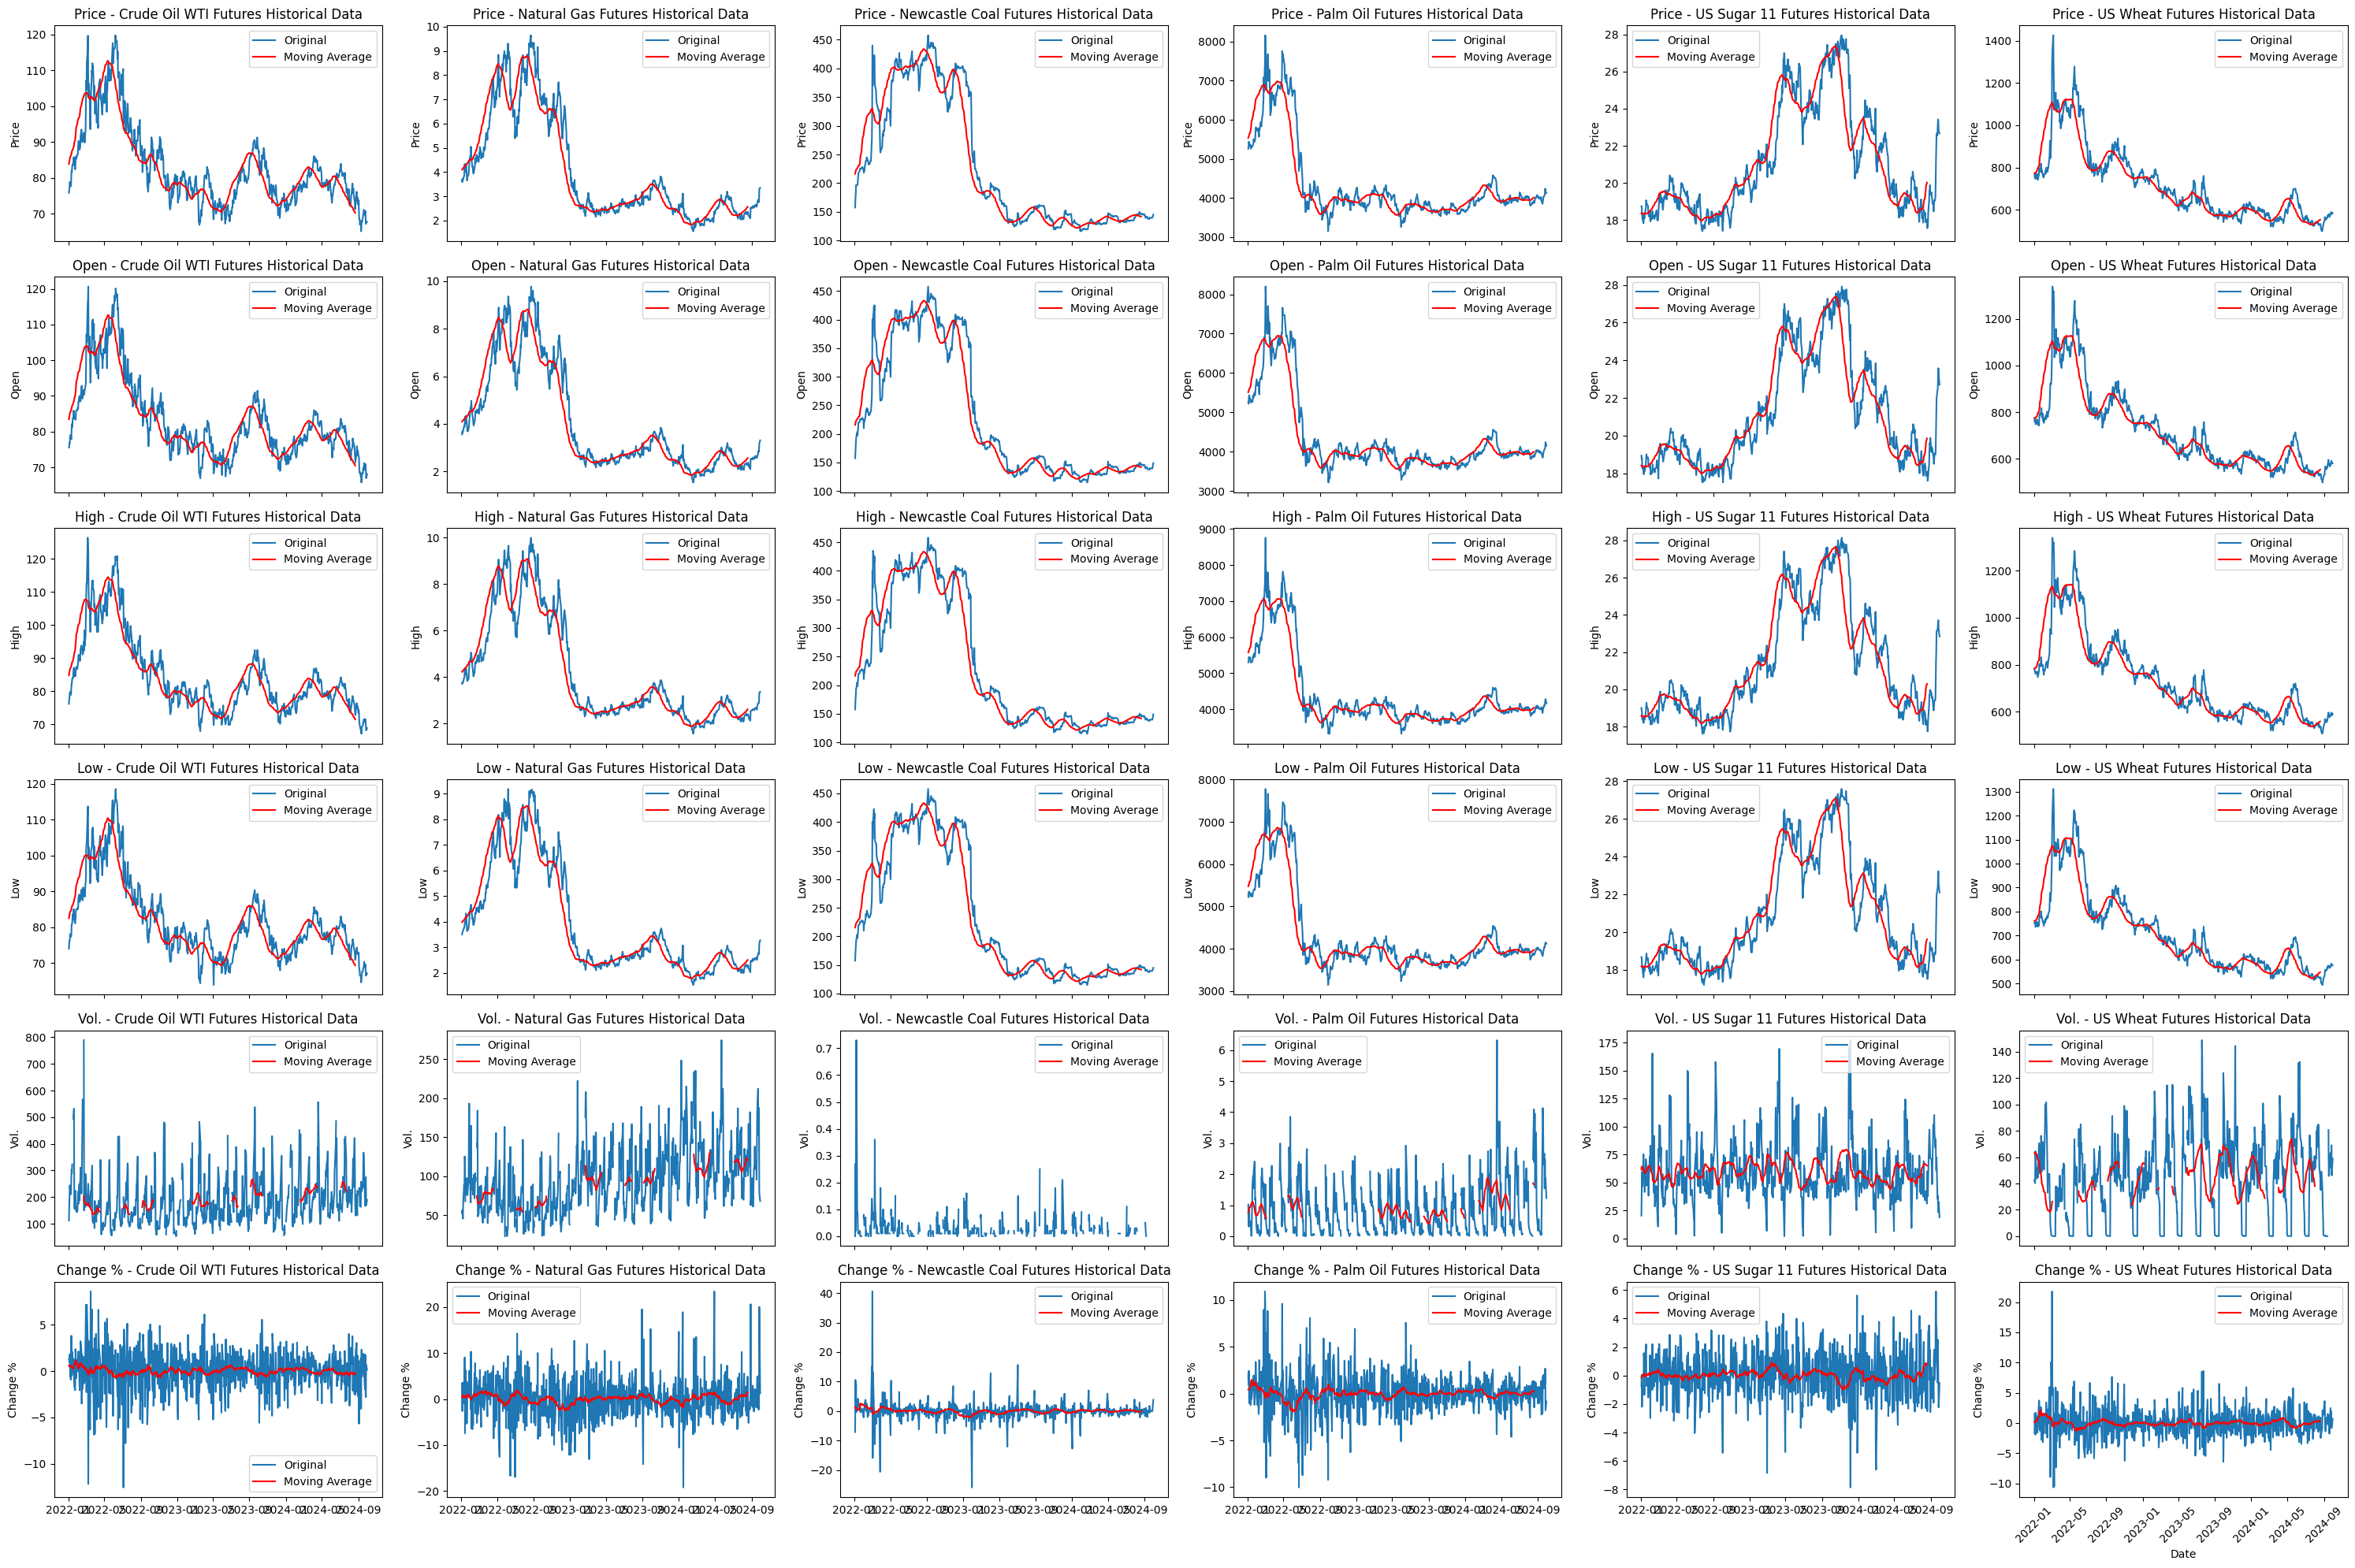

In [ ]:
moving_average_plot(com1, 30)

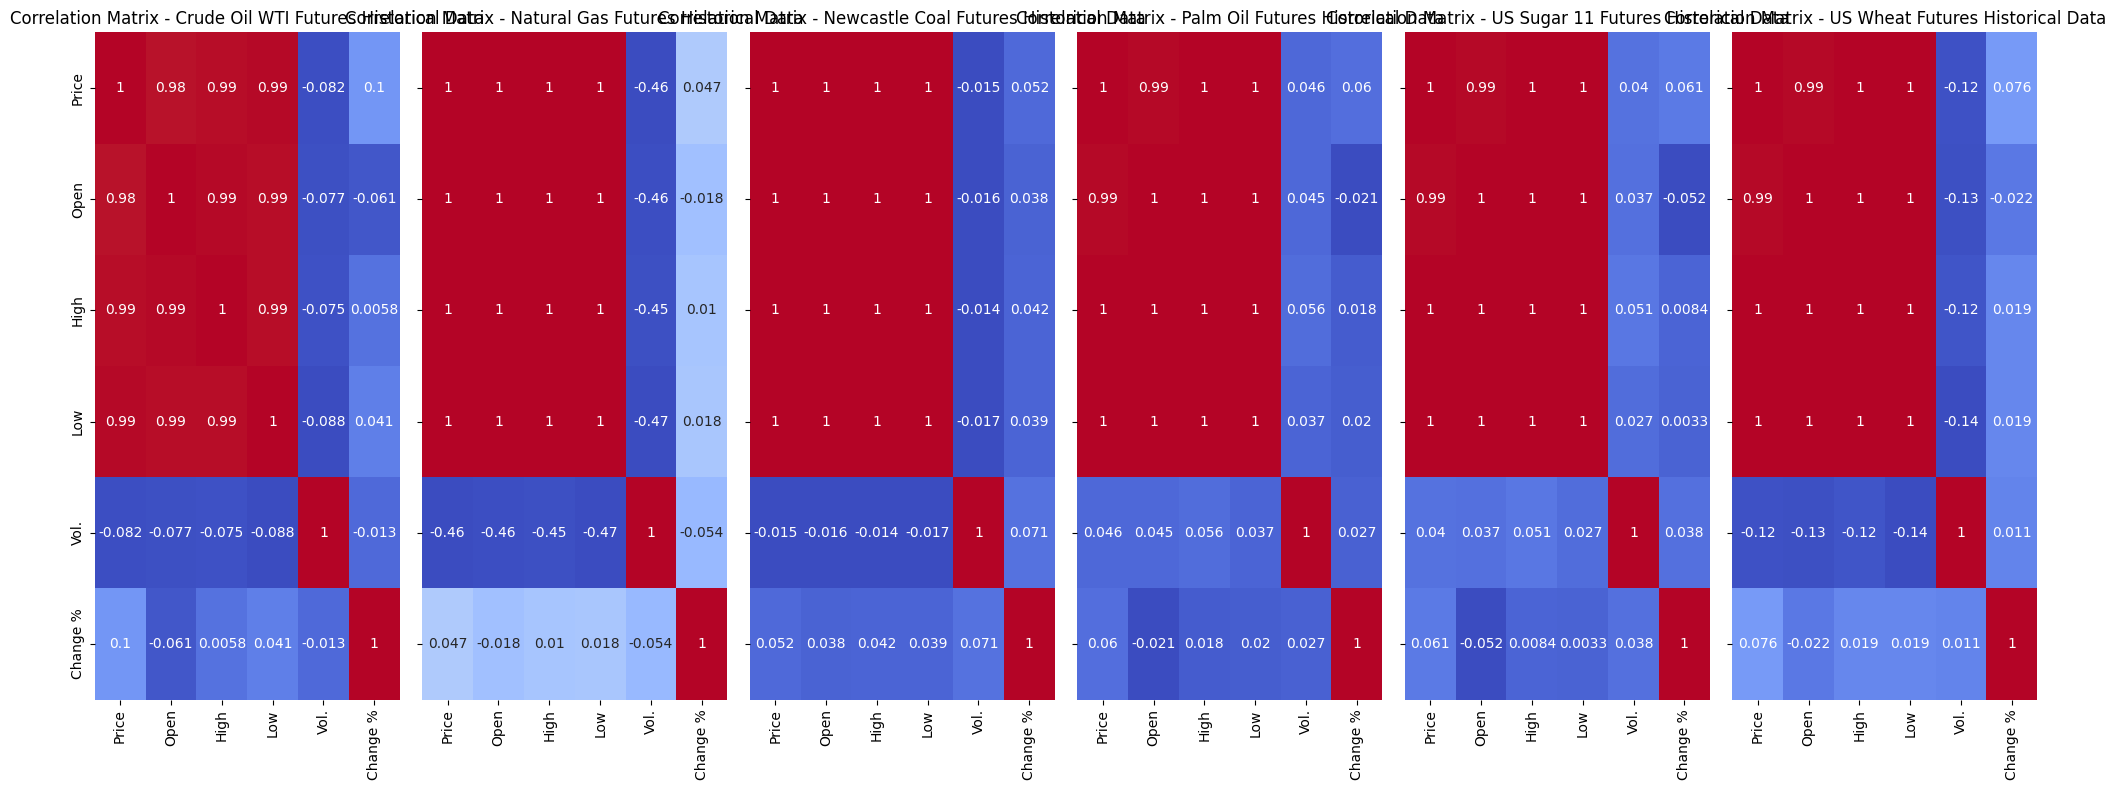

In [ ]:
corr_matrix(com1)

## ARIMA-Related Analysis

In [763]:
adf_test(uang)

ADF Statistic for Date - MYRUSD=X: 0.38677308054891407
p-value: 0.9809935072946818
Critical Values: {'1%': -3.4396596024765795, '5%': -2.86564834926679, '10%': -2.568957779286756}
Date - MYRUSD=X is not stationary

ADF Statistic for Date - SGDUSD=X: 0.38677308054891407
p-value: 0.9809935072946818
Critical Values: {'1%': -3.4396596024765795, '5%': -2.86564834926679, '10%': -2.568957779286756}
Date - SGDUSD=X is not stationary

ADF Statistic for Date - THBUSD=X: 0.38677308054891407
p-value: 0.9809935072946818
Critical Values: {'1%': -3.4396596024765795, '5%': -2.86564834926679, '10%': -2.568957779286756}
Date - THBUSD=X is not stationary

ADF Statistic for Date - USDIDR=X: 0.38677308054891407
p-value: 0.9809935072946818
Critical Values: {'1%': -3.4396596024765795, '5%': -2.86564834926679, '10%': -2.568957779286756}
Date - USDIDR=X is not stationary

ADF Statistic for Adj Close - MYRUSD=X: -1.4292605901365765
p-value: 0.5681706435238989
Critical Values: {'1%': -3.439620010600208, '5%': -2

In [764]:
adf_test(com)

ADF Statistic for Date - Crude Oil WTI Futures Historical Data: -6.263586697279098
p-value: 4.165893395252859e-08
Critical Values: {'1%': -3.439593802573824, '5%': -2.865619356068967, '10%': -2.568942332870462}
Date - Crude Oil WTI Futures Historical Data is stationary

ADF Statistic for Date - Natural Gas Futures Historical Data: -5.3285161693138425
p-value: 4.77802299011424e-06
Critical Values: {'1%': -3.439646367660705, '5%': -2.8656425177031375, '10%': -2.5689546724554404}
Date - Natural Gas Futures Historical Data is stationary

ADF Statistic for Date - Newcastle Coal Futures Historical Data: -6.4018501035479005
p-value: 1.9865673088443656e-08
Critical Values: {'1%': -3.439794053189972, '5%': -2.8657075899001314, '10%': -2.56898934061384}
Date - Newcastle Coal Futures Historical Data is stationary

ADF Statistic for Date - Palm Oil Futures Historical Data: -7.612199741501747
p-value: 2.2397447246129567e-11
Critical Values: {'1%': -3.440357733229128, '5%': -2.8659559257802867, '10%

In [795]:
uang2, d_uang = differentiate_count2(uang)

Skipping feature: Volume in category: MYRUSD=X due to insufficient variability or data.
Skipping feature: Volume in category: SGDUSD=X due to insufficient variability or data.
Skipping feature: Volume in category: THBUSD=X due to insufficient variability or data.
Skipping feature: Volume in category: USDIDR=X due to insufficient variability or data.


In [797]:
uang2.isnull().sum()/uang2.shape[0]

Date         0.00000
Adj Close    0.20000
Category     0.00000
Close        0.15000
High         0.10000
Low          0.05000
Open         0.00000
Volume       0.94993
dtype: float64